# CMS $H \rightarrow ZZ \rightarrow \ell \ell \ell \ell$ Public Outreach Example

CMS has released its higgs discovery dataset as public data. The structure of this is very similar to the ATLAS example, with some important differences:

* CMS data is not a flat ROOT tuple, but a CMS Run 1 AOD.

Outline

1. Use `ServiceX` for general quality and object selection
1. Use `coffea` and `awkward` to do multi-object event wide selection and plots
1. Produce the plot for running on a single MC file
1. Run on all the MC and Data files

In [1]:
from func_adl_servicex import ServiceXSourceCMSRun1AOD
from servicex.servicex import ServiceXDataset
from coffea.processor.servicex import Analysis, DataSource, LocalExecutor
from func_adl import ObjectStream
from hist import Hist

import asyncio
from typing import List

## Defining the base query

* We are using the CMS Run 1 AOD file type here
* No global event cuts

In [2]:
ds = ServiceXSourceCMSRun1AOD('cernopendata://dummy')
ds.return_qastle = True  # Magic

In [3]:
## Selecting Clean Objects

In [4]:
leptons_source = (
    ds
    .Select(lambda e: {
        "m": e.Muons("muons"),
        "e": e.GsfElectrons("gsfElectrons"), 
        "p": e.Vertex("offlinePrimaryVertices")[0].position()
    })
)

In [5]:
data_leptons = (
     leptons_source
     .Select(lambda i: {
          "m": i.m
               .Where(lambda m: m.isPFMuon()
                         and m.isPFIsolationValid()
                         and isNonnull(m.globalTrack())
                         and abs(sqrt((m.globalTrack().dxy(i.p) * m.globalTrack().dxy(i.p))
                                   + (m.globalTrack().dz(i.p) * m.globalTrack().dz(i.p)))
                              / sqrt((m.globalTrack().d0Error() * m.globalTrack().d0Error())
                                        + (m.globalTrack().dzError() * m.globalTrack().dzError()))) < 4.0
                         and abs((m.globalTrack()).dxy(i.p)) < 0.5
                         and abs((m.globalTrack()).dz(i.p)) < 1.
                         and ((m.pfIsolationR04()).sumChargedHadronPt
                              + (m.pfIsolationR04()).sumNeutralHadronEt
                              + (m.pfIsolationR04()).sumPhotonEt) / m.pt() < 0.4
                         and m.pt() > 5.
                         and abs(m.eta()) < 2.4
               ),
          "e": i.e
               .Where(lambda e: e.passingPflowPreselection()
                         and e.pt() > 7.
                         and abs(e.superCluster().eta()) < 2.5
                         and e.gsfTrack().trackerExpectedHitsInner().numberOfHits() <= 1
                         and abs(sqrt((e.gsfTrack().dxy(i.p) * e.gsfTrack().dxy(i.p))
                                   + (e.gsfTrack().dz(i.p) * e.gsfTrack().dz(i.p)))
                              / sqrt((e.gsfTrack().d0Error() * e.gsfTrack().d0Error())
                                        + (e.gsfTrack().dzError() * e.gsfTrack().dzError()))) < 4.
                         and abs(e.gsfTrack().dxy(i.p)) < 0.5 and abs(e.gsfTrack().dz(i.p)) < 1.
                         and (e.isEB() or e.isEE())
                         and (e.pfIsolationVariables().chargedHadronIso
                              + e.pfIsolationVariables().neutralHadronIso
                              + e.pfIsolationVariables().photonIso) / e.pt() < 0.4
                         )
     })
)

And pull out the columns we need for selection in the code

In [6]:
cms_selection = (
    data_leptons
    .Select(lambda i: (
        i.m.Select(lambda m: m.p()),
        i.m.Select(lambda m: m.pt()),
        i.m.Select(lambda m: m.px()),
        i.m.Select(lambda m: m.py()),
        i.m.Select(lambda m: m.pz()),
        i.m.Select(lambda m: m.charge()),
        i.e.Select(lambda m: m.p()),
        i.e.Select(lambda m: m.pt()),
        i.e.Select(lambda m: m.px()),
        i.e.Select(lambda m: m.py()),
        i.e.Select(lambda m: m.pz()),
        i.e.Select(lambda m: m.charge()),
    ))
    .AsROOTTTree('file.root', 'treeme', columns = [
        'mu_p', 'mu_pt', 'mu_px', 'mu_py', 'mu_pz', 'mu_charge',
        'el_p', 'el_pt', 'el_px', 'el_py', 'el_pz', 'el_charge',
    ])
)

## Performing the Analysis

In [12]:
class CMS_Higgs_4L(Analysis):
    '''Run the 4 Lepton analysis on CMS open data Run 1 AOD's
    '''
    @staticmethod
    def process(events):
        from collections import defaultdict
        import numpy as np

        import awkward as ak

        sumw = defaultdict(float)
        mass_hist = (Hist.new
                     .Reg(60, 60, 180, name='mass', label='$m_{4\ell}$ [GeV]')
                     .StrCat([], name='dataset', label='Cut Type', growth=True)
                     .StrCat([], name='channel', label='Channel', growth=True)
                     .Int64()
                    )

        dataset = events.metadata['dataset']
        mass_hist.fill(
            mass=135.0,
            dataset=dataset,
            channel='eeee'
        )

#         electrons = events.electrons
#         muons = events.muons
        
#         weight =  ak.Array(np.ones(len(events.scaleFactor))) if events.metadata['is_data'] \
#             else events.scaleFactor*events.mcWeight

#         # We didn't have the 4-vector in `ServiceX`, so we couldn't do the final good-object cut.
        
#         # Good electon selection
#         electrons_mask = (abs(electrons.z0*np.sin(electrons.theta)) < 0.5)
#         electrons_good = electrons[electrons_mask]

#         # Good muon selection
#         muons_mask = (abs(muons.z0*np.sin(muons.theta)) < 0.5)
#         muons_good = muons[muons_mask]

#         # Next are event level cuts
        
#         # In order to cut in sorted lepton pt, we have to rebuild a lepton array here
#         leptons_good = ak.concatenate((electrons_good, muons_good), axis=1)
#         leptons_good_index = ak.argsort(leptons_good.pt, ascending=False)
#         leptons_good_sorted = leptons_good[leptons_good_index]

#         # Event level cuts now that we know the good leptons
#         # - We need to look at 4 good lepton events only
#         # - We need same flavor, so check for even numbers of each flavor
#         # - all charges must be balenced
#         event_mask = (
#             (ak.num(leptons_good_sorted) == 4)
#             & ((ak.num(electrons_good) == 0) | (ak.num(electrons_good) == 2) | (ak.num(electrons_good) == 4))
#             & ((ak.num(muons_good) == 0) | (ak.num(muons_good) == 2) | (ak.num(muons_good) == 4))
#             & (ak.sum(electrons_good.charge, axis=1) == 0)
#             & (ak.sum(muons_good.charge, axis=1) == 0)
#         )
        
#         # Next, we need to cut on the pT for the leading, sub-leading, and sub-sub-leading lepton
#         leptons_good_preselection = leptons_good[event_mask]
#         event_good_lepton_mask = (
#             (leptons_good_preselection[:,0].pt > 25000.0)
#             & (leptons_good_preselection[:,1].pt > 15000.0)
#             & (leptons_good_preselection[:,2].pt > 10000.0)
#         )

#         # Now, we need to rebuild the good muon and electron lists with those selections
#         muons_analysis = muons_good[event_mask][event_good_lepton_mask]
#         electrons_analysis = electrons_good[event_mask][event_good_lepton_mask]

#         # Lets do eemumu events - as there are no permutations there.abs
#         # At this point if there are two muons, there must be two electrons
#         eemumu_mask = (ak.num(muons_analysis) == 2)
#         muon_eemumu = muons_analysis[eemumu_mask]
#         electrons_eemumu = electrons_analysis[eemumu_mask]
#         z1_eemumu = muon_eemumu[:,0] + muon_eemumu[:,1]
#         z2_eemumu = electrons_eemumu[:,0] + electrons_eemumu[:,1]
#         h_eemumu = z1_eemumu + z2_eemumu

#         sumw[dataset] += len(h_eemumu)
#         mass_hist.fill(
#             channel=r'$ee\mu\mu$',
#             mass=h_eemumu.mass/1000.0,
#             dataset=dataset,
#             weight=weight[eemumu_mask]
#         )

#         # Next, eeee. For this we have to build permutations and select the best one
#         def four_leptons_one_flavor(same_flavor_leptons, event_weights, channel: str):
#             fl_positive = same_flavor_leptons[same_flavor_leptons.charge > 0]
#             fl_negative = same_flavor_leptons[same_flavor_leptons.charge < 0]
#             fl_pairs = ak.cartesian((fl_positive, fl_negative))
#             # fl_pairs_args = ak.argcartesian((fl_positive, fl_negative))
#             zs = fl_pairs["0"] + fl_pairs["1"]

#             delta = abs((91.18*1000.0) - zs.mass[:])
#             closest_masses = np.min(delta, axis=-1)
#             the_closest = (delta == closest_masses)
#             the_furthest = the_closest[:,::-1]

#             h_eeee = zs[the_closest] + zs[the_furthest]
#             sumw[dataset] += len(h_eeee)
#             mass_hist.fill(
#                 channel=channel,
#                 mass=ak.flatten(h_eeee.mass/1000.0),
#                 dataset=dataset,
#                 weight=event_weights,
#             )

#         four_leptons_one_flavor(electrons_analysis[(ak.num(electrons_analysis) == 4)],
#                                 weight[(ak.num(electrons_analysis) == 4)],
#                                 '$eeee$')
#         four_leptons_one_flavor(muons_analysis[(ak.num(muons_analysis) == 4)],
#                                 weight[(ak.num(muons_analysis) == 4)],
#                                 '$\\mu\\mu\\mu\\mu$')
        
        return {
            "sumw": sumw,
            "mass": mass_hist,
        }

# Run on a MC File

Again, we will run on a CMS Higgs MC sample to demonstrate this all works before unleashing it on all the data samples.

In [13]:
def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    from utils import cms_files
    datasets = [ServiceXDataset(cms_files[name]['files'], backend_type='cms_run1_aod')]
    return DataSource(query=query, metadata={'dataset': name, 'is_data': False}, datasets=datasets)

In [14]:
from utils import cms_files
all_datasets = list(cms_files.keys())
', '.join(all_datasets)

'SMHiggsToZZTo4L_M-125_7TeV'

The routine that will run on multiple datasets

In [15]:
async def run_analysis(names: List[str]):
    'Generate base plot for a multiple datafiles'

    executor = LocalExecutor(datatype='root')
    datasources = [make_ds(ds_name, cms_selection) for ds_name in names]

    # Create the analysis and we can run from there.
    analysis = CMS_Higgs_4L()

    async def run_updates_stream(accumulator_stream, name):
        '''Run to get the last item in the stream, with a useful error message'''
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f'Failure while processing {name}') from e
        return coffea_info

    # Run on all items and wait till they are done!
    all_plots = await asyncio.gather(*[run_updates_stream(executor.execute(analysis, source), source.metadata['dataset']) for source in datasources])
    
    all_plots_mass = [p['mass'] for p in all_plots]
    mass = all_plots_mass[0]
    for p in all_plots_mass[1:]:
        mass += p

    return mass

In [16]:
mc_mass_plot = await run_analysis(['SMHiggsToZZTo4L_M-125_7TeV'])

c:\users\gordo\code\pyhep-2021-sx-opendatademo\.venv\lib\site-packages\lark\parsers\earley.py:131: RuntimeWarning: coroutine 'LocalExecutor._async_analysis' was never awaited
  new_item = Item(rule, 0, i)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x0000022A7C9394F0>, errorbar=None, legend_artist=None)]

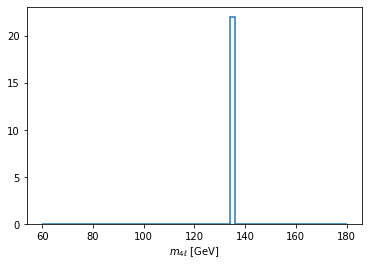

In [19]:
mc_mass_plot.project('mass', 'dataset').plot()